# Estimate Neural Manifold Riemannian Metric

### Set-up + Imports

In [35]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import os

import matplotlib.pyplot as plt
import numpy as np
import torch

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [57]:
import neurometry.datasets.synthetic as synthetic

task_points = synthetic.hypersphere(1, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array([5, 3, 1]),
)

noise level: 7.07%


In [58]:
# Plot noisy_points and manifold_points in 3D with plotly

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=noisy_points[:, 0],
        y=noisy_points[:, 1],
        z=noisy_points[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=manifold_points[:, 0],
        y=manifold_points[:, 1],
        z=manifold_points[:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.show()

In [64]:
from neurometry.geometry.topology.persistent_homology import compute_diagrams_shuffle

num_shuffles = 100

noisy_diagrams = compute_diagrams_shuffle(noisy_points, num_shuffles=num_shuffles)

manifold_diagrams = compute_diagrams_shuffle(manifold_points, num_shuffles=num_shuffles)

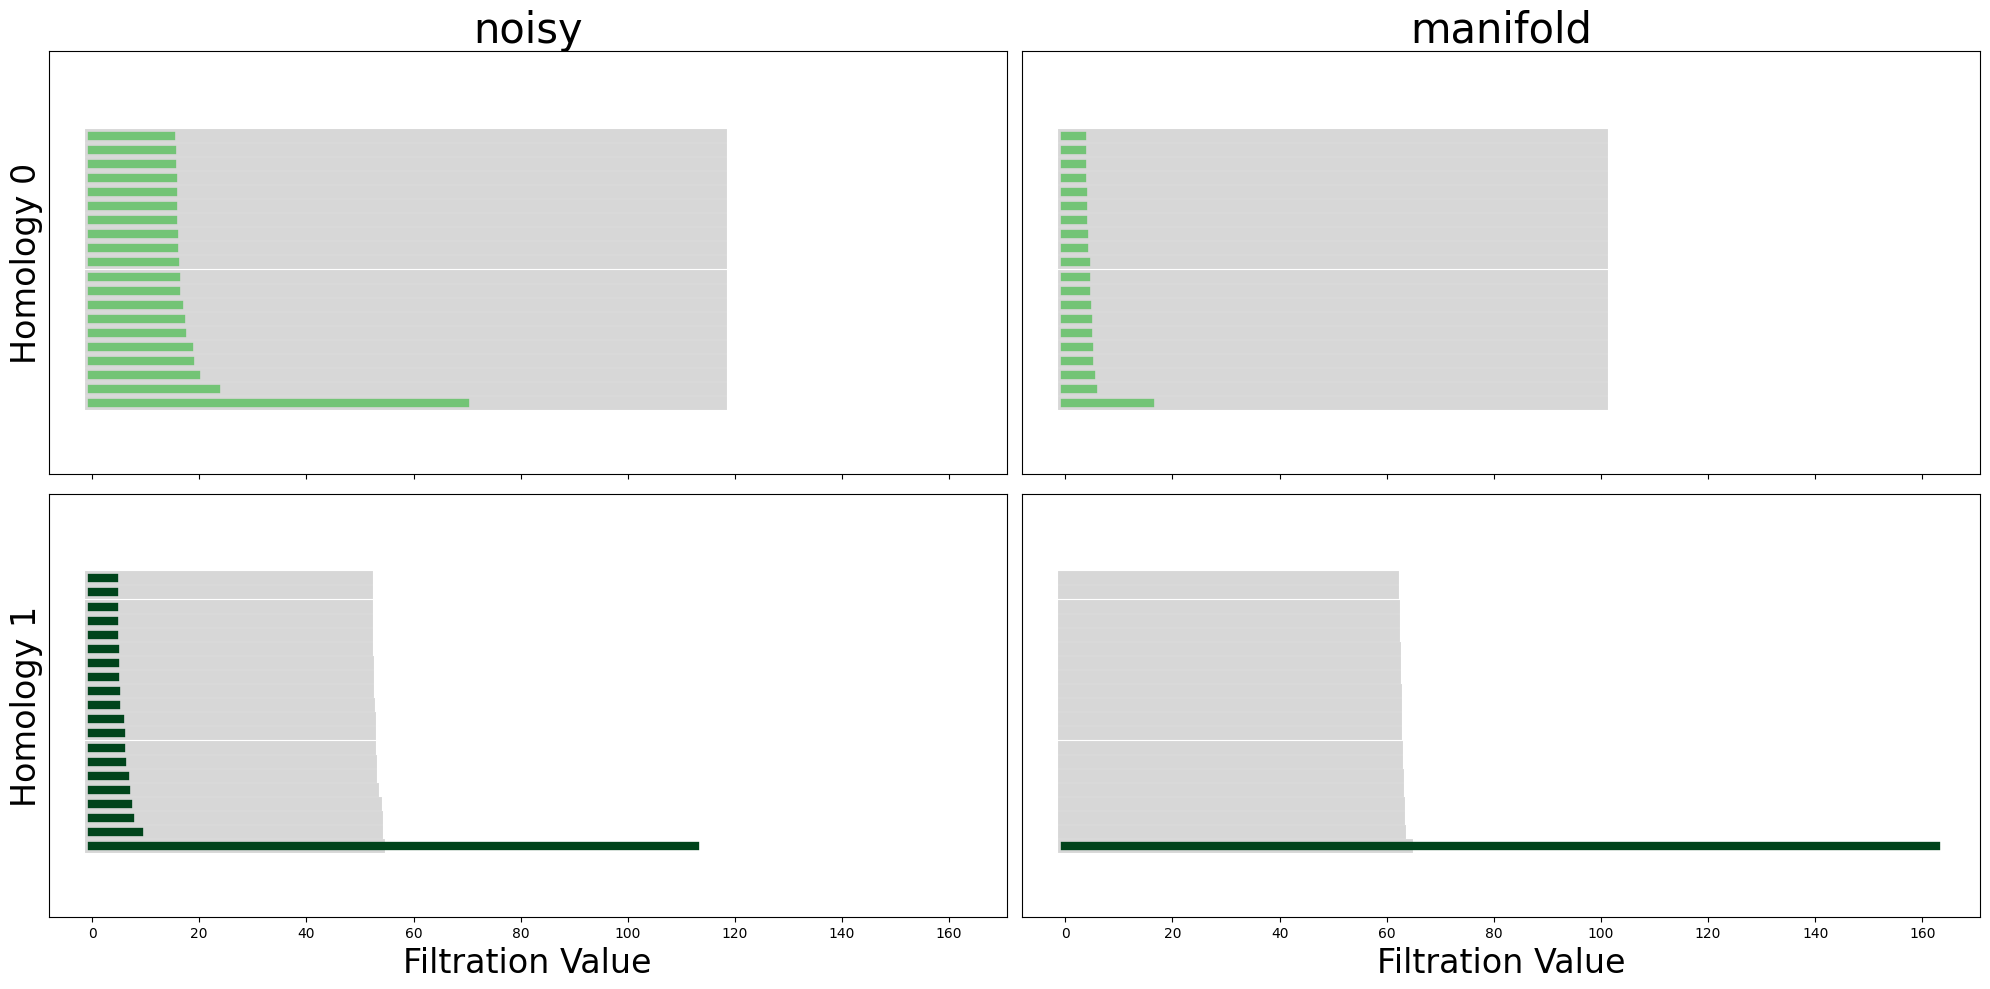

In [65]:
from neurometry.geometry.topology.plotting import plot_all_barcodes_with_null

plot_all_barcodes_with_null(
    noisy_diagrams, "noisy", diagrams_2=manifold_diagrams, dataset_name_2="manifold"
);

In [ ]:
diagram_dim = original_diagram[original_diagram[:, 2] == dim]
null_diagram_dim = shuffled_diagrams[:, :, 2] == dim
null_diagram = shuffled_diagrams[null_diagram_dim]

null_lifespans_dim = _get_lifespan_from_diagram(null_diagram)
lifespans_dim = _get_lifespan_from_diagram(diagram_dim)

In [76]:
all_diagrams.shape

diag = all_diagrams[0]

shuff_diag = all_diagrams[1:]

In [94]:
filtered_shuff_diag = np.array(
    [shuff_diag[i, shuff_diag[i, :, 2] == 1] for i in range(shuff_diag.shape[0])]
)

filtered_shuff_diag.shape

(100, 51, 3)

In [96]:
def _get_lifespan_from_diagram(diagram):
    birth = diagram[:, 0]
    death = diagram[:, 1]
    if np.isfinite(death).any():
        inf_value = 3 * np.max(death[death != np.inf])
    else:
        inf_value = 1000
    death[death == np.inf] = inf_value
    lifespan = death - birth
    indices = np.argsort(-lifespan)[:20]

    return lifespan[indices]

In [99]:
def estimate_betti_numbers(points, num_shuffles, homology_dimensions=(0, 1, 2)):
    all_diagrams = compute_diagrams_shuffle(
        points, num_shuffles=num_shuffles, homology_dimensions=homology_dimensions
    )
    diagram = all_diagrams[0]
    shuffled_diagrams = all_diagrams[1:]

    betti_numbers = {dim: None for dim in homology_dimensions}

    for dim in homology_dimensions:
        filtered_diagram = diagram[diagram[:, 2] == dim]
        lifespan = _get_lifespan_from_diagram(filtered_diagram)
        filtered_shuffled_diagrams = np.array(
            [
                shuffled_diagrams[i, shuffled_diagrams[i, :, 2] == 1]
                for i in range(shuffled_diagrams.shape[0])
            ]
        )
        betti_number = []
        for diag in filtered_shuffled_diagrams:
            shuffled_lifespan = _get_lifespan_from_diagram(diag)
            significant_features = (lifespan > shuffled_lifespan).astype(int)
            betti_number.append(sum(significant_features))
        betti_numbers[dim] = (np.mean(betti_number), np.std(betti_number))

    return betti_numbers

In [100]:
betti_numbers = estimate_betti_numbers(
    manifold_points, num_shuffles=100, homology_dimensions=(0, 1)
)
print(betti_numbers)

{0: (0.0, 0.0), 1: (1.0, 0.0)}


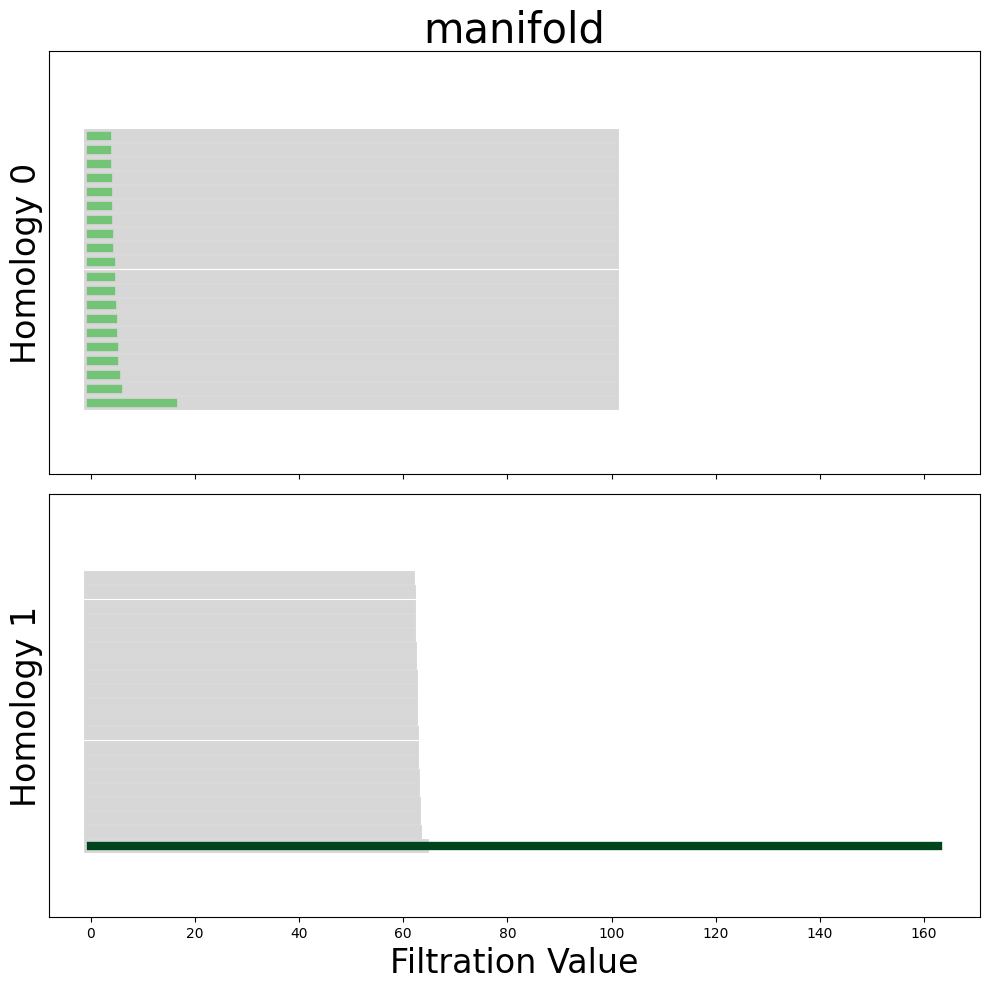

In [67]:
homology_dimensions = (0, 1)
points = manifold_points
num_shuffles = 100

all_diagrams = compute_diagrams_shuffle(
    points, num_shuffles=num_shuffles, homology_dimensions=homology_dimensions
)

plot_all_barcodes_with_null(all_diagrams, "manifold")


diagram = all_diagrams[0]
lifespan = _get_lifespan_from_diagram(diagram)
shuffled_diagrams = all_diagrams[1:]

betti_numbers = {dim: None for dim in homology_dimensions}

for dim in homology_dimensions:
    betti_number = []
    for shuffled_diagram in shuffled_diagrams:
        shuffled_lifespan = _get_lifespan_from_diagram(shuffled_diagram)
        significant_features = (lifespan > shuffled_lifespan).astype(int)
        betti_number.append(sum(significant_features))
    betti_numbers[dim] = np.mean(betti_number)

In [32]:
def get_betti_numbers(diagrams):
    original_diagram = diagrams[0]
    shuffled_diagrams = diagrams[1:]

    dims = np.unique(original_diagram[:, 2]).astype(int)

    betti_numbers = {dim: None for dim in dims}
    for i, dim in enumerate(dims):
        diagram_dim = original_diagram[original_diagram[:, 2] == dim]
        null_diagram_dim = shuffled_diagrams[:, :, 2] == dim
        null_diagram = shuffled_diagrams[null_diagram_dim]

        null_lifespans_dim = _get_lifespan_from_diagram(null_diagram)
        lifespans_dim = _get_lifespan_from_diagram(diagram_dim)

        comparison = (lifespans_dim > null_lifespans_dim).astype(int)

        betti_numbers[dim] = sum(comparison)

    return betti_numbers

In [33]:
betti = get_betti_numbers(noisy_diagrams)

In [34]:
betti

{0: 0, 1: 5, 2: 2}

### 2-Torus Betti numbers

In [101]:
task_points = synthetic.hypertorus(2, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=10,
    nonlinearity="sigmoid",
    scales=gs.ones(10),
    poisson_multiplier=100,
)

noise level: 0.71%


In [105]:
betti_numbers = estimate_betti_numbers(
    manifold_points, num_shuffles=500, homology_dimensions=(0, 1)
)
print(betti_numbers)

{0: (19.814, 0.7066852198822331), 1: (13.214, 2.555817677378416)}


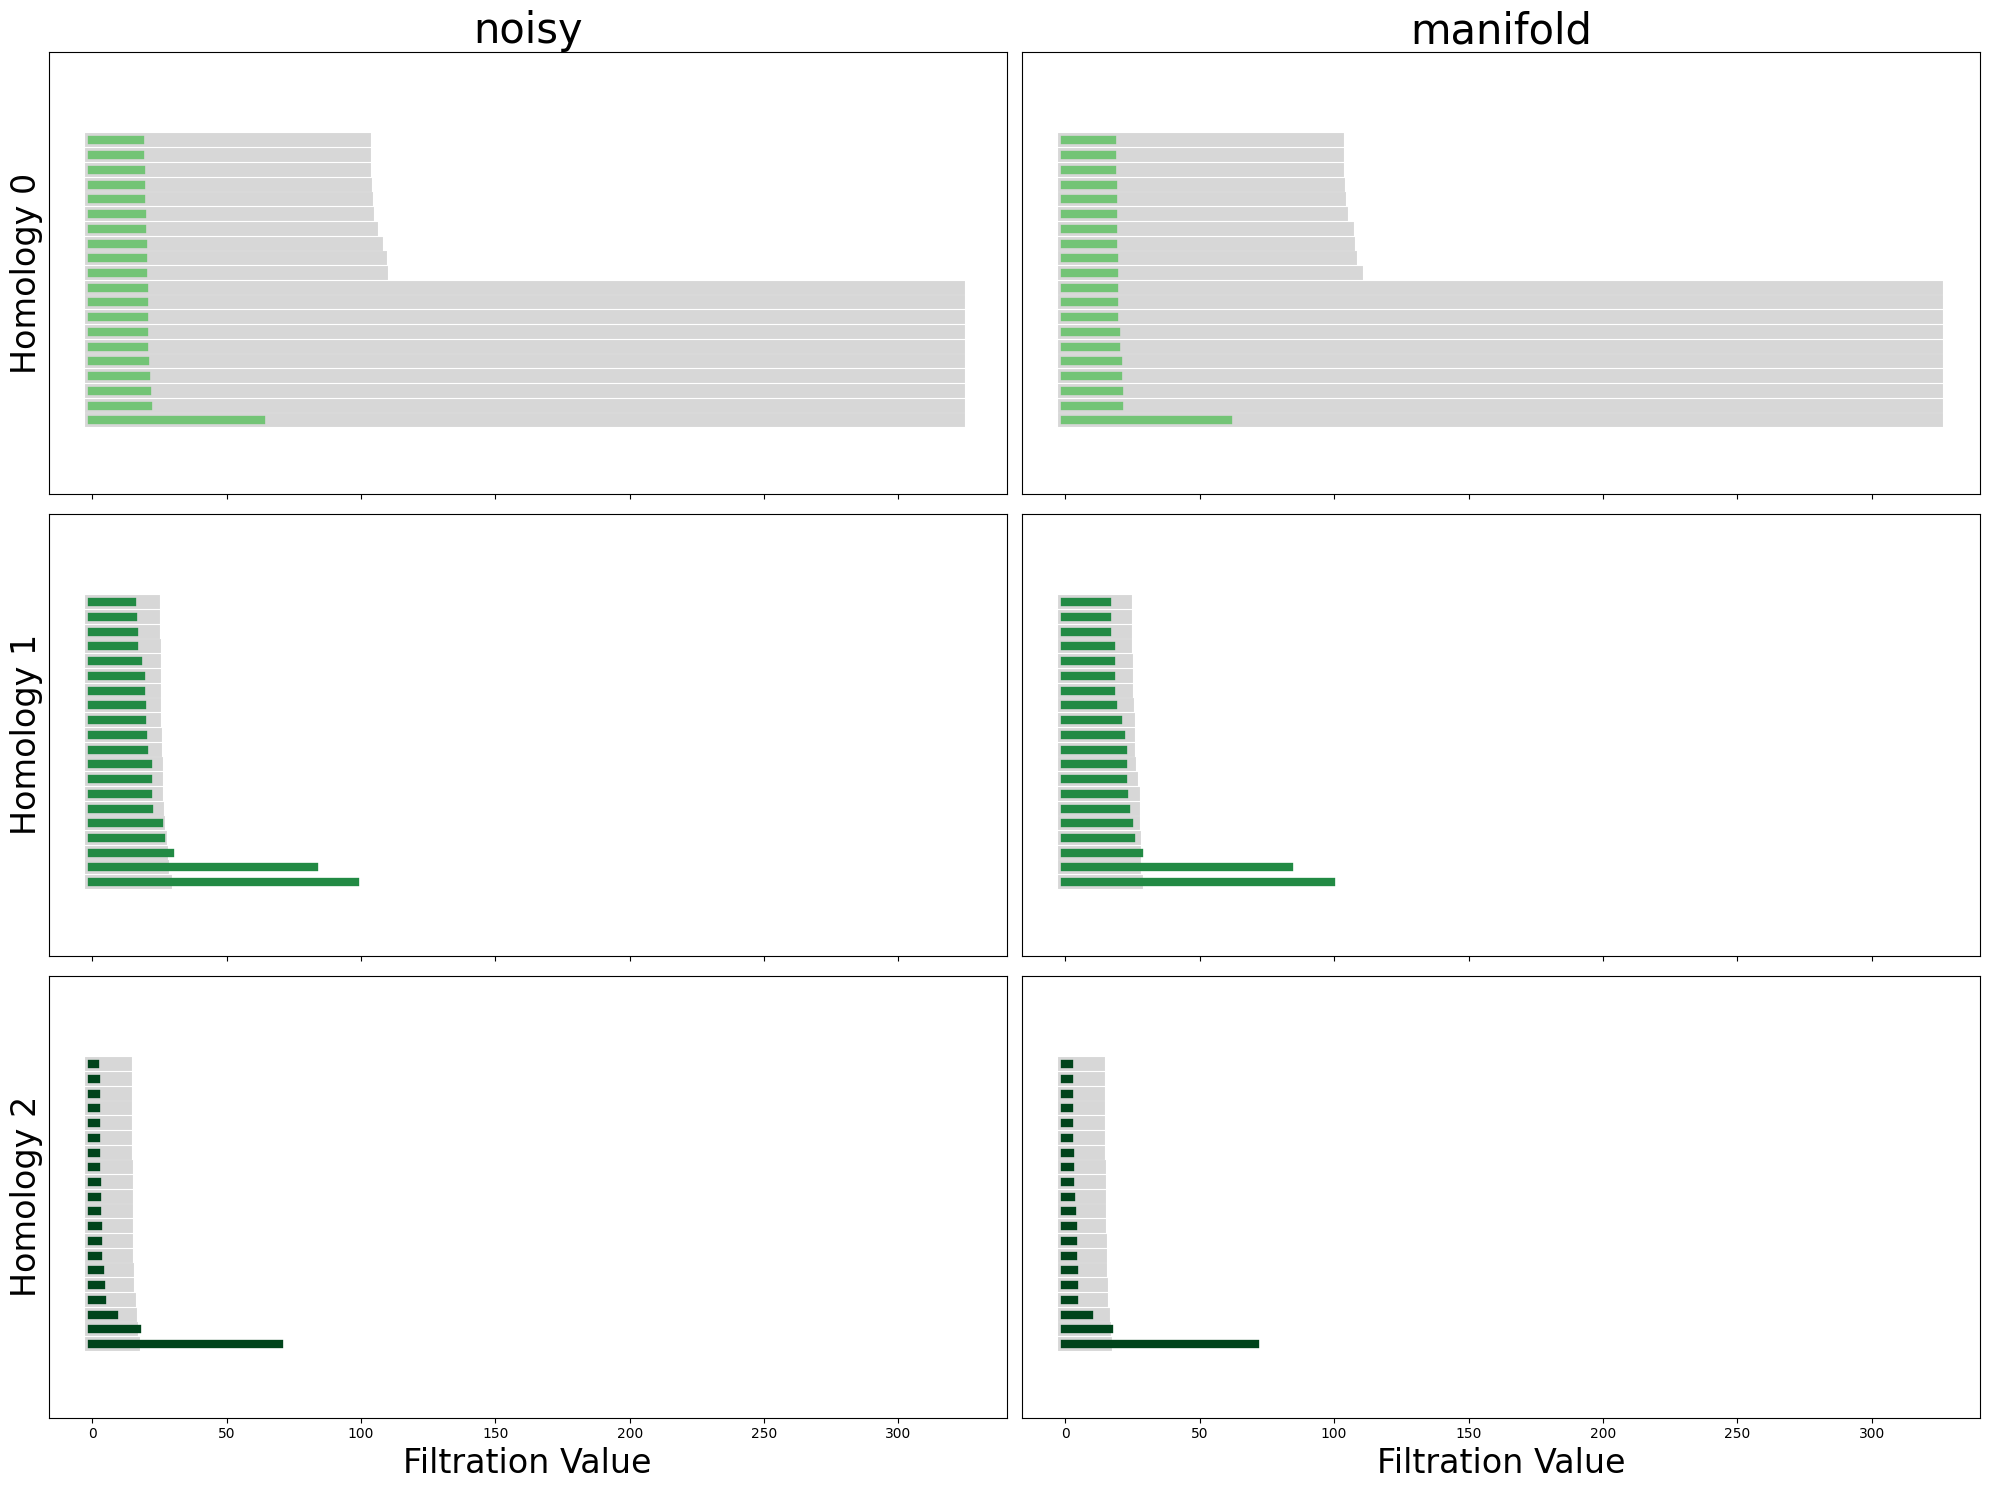

In [12]:
num_shuffles = 10

noisy_diagrams = compute_diagrams_shuffle(
    noisy_points, num_shuffles=num_shuffles, homology_dimensions=(0, 1, 2)
)

manifold_diagrams = compute_diagrams_shuffle(
    manifold_points, num_shuffles=num_shuffles, homology_dimensions=(0, 1, 2)
)

plot_all_barcodes_with_null(
    noisy_diagrams, "noisy", diagrams_2=manifold_diagrams, dataset_name_2="manifold"
);

In [13]:
betti = get_betti_numbers(noisy_diagrams)
print(betti)

{0: 0, 1: 5, 2: 2}


In [17]:
from gtda.diagrams import PersistenceEntropy

persistent_entropy = PersistenceEntropy()

X_basic = persistent_entropy.fit_transform(noisy_diagrams)

X_basic.shape

(11, 3)

In [29]:
# 3d plot of X_basic, color first point (X_basic[0, :]) red, and all other points blue

fig = go.Figure()


fig.add_trace(
    go.Scatter3d(
        x=X_basic[1:, 0],
        y=X_basic[1:, 1],
        z=X_basic[1:, 2],
        mode="markers",
        marker=dict(size=3),
    )
)

fig.add_trace(
    go.Scatter3d(
        x=[X_basic[0, 0]],
        y=[X_basic[0, 1]],
        z=[X_basic[0, 2]],
        mode="markers",
        marker=dict(size=3, color="red"),
    )
)

fig.show()

### TODO: FIX get_betti_numbers FUNCTION!!!!

Also: how to deal with betti 0 ? There should be a single "significant" feature?

In [14]:
sphere_1_betti = {0: 1, 1: 1, 2: 0}
torus_2_betti = {0: 1, 1: 2, 2: 1}
sphere_2_betti = {0: 1, 1: 0, 2: 1}

# if betti == sphere_1_betti:
#     print("The manifold is a ring") ----> use ring VAE


# elif betti == torus_2_betti:

In [31]:
A = np.array([1, 3, 5, 7])
B = np.array([2, 2, 6, 8])

# Perform the element-wise comparison B > A
C = (B > A).astype(int)

print(sum(C))

3
